+ (-1, 1)
+ min length: 1% of 2
+ max length: 20% of 2
+ 2000 pairs
+ 1000 overlaps
+ 1000 not
+ max radius: 5
+ min radius: 0.5

#### Prepare Data

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.8 MB/s eta 0:00:00


In [ ]:
import torch
import gpytorch
import numpy as np
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_Center_sample_1 = pd.read_excel('/content/drive/MyDrive/Obeject_trajectory_research/Part II/df_Center_sample_1.xlsx')
df_Center_sample_1.head()

,Float_Value,Center_X,Center_Y,Center_Z
0,0.395949,0.738760,0.802025,-0.088049
1,0.585647,-0.121529,0.199795,0.015834
2,0.598017,0.291581,0.008656,-0.102974
3,0.227400,-0.344506,-0.507927,0.886300
4,0.651940,0.564914,0.009611,0.215109


In [ ]:
df_Center_sample_2 = pd.read_excel('/content/drive/MyDrive/Obeject_trajectory_research/Part II/df_Center_sample_2.xlsx')
df_Center_sample_2.head()

,Float_Value,Center_X,Center_Y,Center_Z
0,0.589843,0.705079,0.341658,0.233178
1,0.390631,-0.414054,0.218725,0.428117
2,0.493305,0.753348,-0.142957,0.410415
3,0.378909,-0.389555,-0.431636,0.683925
4,0.191627,0.904187,0.208935,-0.108930


In [ ]:
cube1_centers = df_Center_sample_1[['Center_X', 'Center_Y', 'Center_Z']].values
cube2_centers = df_Center_sample_2[['Center_X', 'Center_Y', 'Center_Z']].values
cube1_sizes = df_Center_sample_1['Float_Value'].values
cube2_sizes = df_Center_sample_2['Float_Value'].values

# Compute min and max bounds for cube1 and cube2
cube1_min = cube1_centers - cube1_sizes[:, None] / 2
cube1_max = cube1_centers + cube1_sizes[:, None] / 2
cube2_min = cube2_centers - cube2_sizes[:, None] / 2
cube2_max = cube2_centers + cube2_sizes[:, None] / 2

# Check overlap for each dimension
x_overlap = (cube1_min[:, 0] <= cube2_max[:, 0]) & (cube1_max[:, 0] >= cube2_min[:, 0])
y_overlap = (cube1_min[:, 1] <= cube2_max[:, 1]) & (cube1_max[:, 1] >= cube2_min[:, 1])
z_overlap = (cube1_min[:, 2] <= cube2_max[:, 2]) & (cube1_max[:, 2] >= cube2_min[:, 2])

# Combine conditions for overall overlap
overlap = (x_overlap & y_overlap & z_overlap).astype(int)
isOverlap = pd.DataFrame(overlap)

In [ ]:
overlap_counts = isOverlap.value_counts()

# Separate counts for 1s and 0s
count_ones = overlap_counts.get(1, 0)
count_zeros = overlap_counts.get(0, 0)

print(f"Count of 1s (overlapping): {count_ones}")
print(f"Count of 0s (non-overlapping): {count_zeros}")

Count of 1s (overlapping): 34897
Count of 0s (non-overlapping): 34897


#### Generate (u,v,w)

In [ ]:
import math

In [ ]:
def fibonacci_unit_sphere(samples=1000):

    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points

In [ ]:
# Sample points on 3D hemisphere with x >= 0
def sample_xyz_hemisphere_radial(radius_max, spoke_count, samples_per_spoke, divisor_spoke):
    # Uniformly sample points on the surface of a sphere
    points_unit_sphere_list = fibonacci_unit_sphere(2*spoke_count)

    # Retain only those with u >= 0
    points_unit_hemisphere_list = [point for point in points_unit_sphere_list if point[0] >= 0]

    # Set up sample distances along spoke
    radii_unit_spoke_list = [1/math.pow(divisor_spoke, i) for i in range(samples_per_spoke)]

    # Make samples along spokes
    # Compute outer product of points_unit_hemisphere_list and radii_unit_spoke_list
    points_list = [(point[0]*radius*radius_max, point[1]*radius*radius_max, point[2]*radius*radius_max) for point in points_unit_hemisphere_list for radius in radii_unit_spoke_list]

    # Add one more at (0,0,0)
    points_list.append((0,0,0))

    return points_list

#### Fourier Transform

In [ ]:
def cuboid_fourier_transform_batch(u_vals, v_vals, w_vals, a, b, c, x0, y0, z0):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert inputs to tensors and move to the specified device
    u_tensor = torch.tensor(u_vals, dtype=torch.float32, device=device)
    v_tensor = torch.tensor(v_vals, dtype=torch.float32, device=device)
    w_tensor = torch.tensor(w_vals, dtype=torch.float32, device=device)

    # Handle the division by zero cases using torch.where
    a_part = torch.where(u_tensor == 0, torch.tensor(a, device=device), torch.sin(torch.pi * a * u_tensor) / (torch.pi * u_tensor))
    b_part = torch.where(v_tensor == 0, torch.tensor(b, device=device), torch.sin(torch.pi * b * v_tensor) / (torch.pi * v_tensor))
    c_part = torch.where(w_tensor == 0, torch.tensor(c, device=device), torch.sin(torch.pi * c * w_tensor) / (torch.pi * w_tensor))

    # Combine parts (vectorized batch computation)
    abc_part = a_part * b_part * c_part

    # Calculate angles (vectorized for batch input)
    angle = 2 * torch.pi * (u_tensor * x0 + v_tensor * y0 + w_tensor * z0)

    # Real and Imaginary parts of the Fourier transform
    real_part = abc_part * torch.cos(angle)
    imag_part = -abc_part * torch.sin(angle)

    return real_part, imag_part

#### MLP Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

#### Loop

In [ ]:
radius = [i * 0.05 for i in range(1, int(2 / 0.05) + 1)]
print(radius)

[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0, 1.05, 1.1, 1.1500000000000001, 1.2000000000000002, 1.25, 1.3, 1.35, 1.4000000000000001, 1.4500000000000002, 1.5, 1.55, 1.6, 1.6500000000000001, 1.7000000000000002, 1.75, 1.8, 1.85, 1.9000000000000001, 1.9500000000000002, 2.0]


In [ ]:
radius = radius[38:]
print(radius)

[1.9500000000000002, 2.0]


In [ ]:
import torch

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cube1_centers = torch.tensor(df_Center_sample_1[['Center_X', 'Center_Y', 'Center_Z']].values, dtype=torch.float32).to(device)
cube1_sizes = torch.tensor(df_Center_sample_1['Float_Value'].values, dtype=torch.float32).to(device)

cube2_centers = torch.tensor(df_Center_sample_2[['Center_X', 'Center_Y', 'Center_Z']].values, dtype=torch.float32).to(device)
cube2_sizes = torch.tensor(df_Center_sample_2['Float_Value'].values, dtype=torch.float32).to(device)

In [ ]:
training_metrics = []
test_metrics = []

training_auc = []
test_auc = []

In [ ]:
for r in radius:
  radius_max = r
  spoke_count = 50
  samples_per_spoke = 10
  divisor_spoke = 1.2
  points_list = sample_xyz_hemisphere_radial(radius_max, spoke_count, samples_per_spoke,divisor_spoke)

  df_points_list = pd.DataFrame(points_list,columns=['u','v','w'])

  u_vals = df_points_list['u'].values
  v_vals = df_points_list['v'].values
  w_vals = df_points_list['w'].values

  FT_arr = []

  for i in range(len(df_Center_sample_1)):
    #Cube1
    x1_0, y1_0, z1_0 = cube1_centers[i]
    a1 = b1 = c1 = cube1_sizes[i]

    real_part_1, imag_part_1 = cuboid_fourier_transform_batch(u_vals, v_vals, w_vals, a1, b1, c1, x1_0, y1_0, z1_0)

    #Cube2
    x2_0, y2_0, z2_0 = cube2_centers[i]
    a2 = b2 = c2 = cube2_sizes[i]

    real_part_2, imag_part_2 = cuboid_fourier_transform_batch(u_vals, v_vals, w_vals, a2, b2, c2, x2_0, y2_0, z2_0)

    FT_arr.append(real_part_1 + imag_part_1 + real_part_2 + imag_part_2)


  #Split train and test
  FT_arr_train, FT_arr_test, overlap_train, overlap_test = train_test_split(FT_arr, isOverlap, test_size=0.2, random_state=42)

  X = FT_arr_train
  y = np.array(overlap_train)

  #Convert to tensors
  x_train_tensor = torch.stack(X)
  y_train_tensor = torch.tensor(y, dtype=torch.long)
  y_train_tensor = y_train_tensor.squeeze()  # Convert shape

  # Define dataset and dataloader
  dataset = CustomDataset(x_train_tensor, y_train_tensor.long())
  dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

  # Model Parameters
  input_size = 511
  hidden_size = 64
  num_classes = len(torch.unique(y_train_tensor))

  # Initialize the model, loss, and optimizer
  model = MLP(input_size, hidden_size, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  epochs = 200
  for epoch in range(epochs):
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)

      # Compute the loss
      loss = criterion(outputs, labels)

      # Backward pass
      loss.backward()

      # Update weights
      optimizer.step()

  ################################################Prediction for training set#############################################################################
  model.eval()

  with torch.no_grad():
    outputs = model(x_train_tensor)
    _, predicted = torch.max(outputs, 1)

  y_true = y_train_tensor.squeeze().numpy()
  y_pred = predicted.cpu().numpy()

  auc = roc_auc_score(y_true, y_pred)
  conf_matrix = confusion_matrix(y_true, y_pred)
  if conf_matrix.shape == (2, 2):
    tn, fp, fn, tp = conf_matrix.ravel()
  else:
    raise ValueError("This code is designed for binary classification. Adjust for multi-class.")

  # Calculate metrics for train
  FNR = fn / (tp + fn) if (tp + fn) != 0 else 0  # False Negative Rate
  FPR = fp / (tn + fp) if (tn + fp) != 0 else 0  # False Positive Rate
  TPR = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate
  TNR = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate

  training_metrics.append((FNR, FPR, TPR, TNR))
  training_auc.append(auc)

  ################################################Prediction for test set#############################################################################
  X_test = FT_arr_test
  y_test = np.array(overlap_test)

  # Convert to tensors
  x_test_tensor = torch.stack(X_test)
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)
  y_test_tensor = y_test_tensor.squeeze()

  model.eval()

  with torch.no_grad():
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs, 1)

  y_true = y_test_tensor.squeeze().numpy()
  y_pred = predicted.cpu().numpy()

  auc = roc_auc_score(y_true, y_pred)
  conf_matrix = confusion_matrix(y_true, y_pred)
  if conf_matrix.shape == (2, 2):
    tn, fp, fn, tp = conf_matrix.ravel()
  else:
    raise ValueError("This code is designed for binary classification. Adjust for multi-class.")

  # Calculate metrics for test
  FNR = fn / (tp + fn) if (tp + fn) != 0 else 0  # False Negative Rate
  FPR = fp / (tn + fp) if (tn + fp) != 0 else 0  # False Positive Rate
  TPR = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate
  TNR = tn / (tn + fp) if (tn + fp) != 0 else 0  # True Negative Rate

  test_metrics.append((FNR, FPR, TPR, TNR))
  test_auc.append(auc)


<ipython-input-12-04c61639f586>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_part = torch.where(u_tensor == 0, torch.tensor(a, device=device), torch.sin(torch.pi * a * u_tensor) / (torch.pi * u_tensor))
<ipython-input-12-04c61639f586>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_part = torch.where(v_tensor == 0, torch.tensor(b, device=device), torch.sin(torch.pi * b * v_tensor) / (torch.pi * v_tensor))
<ipython-input-12-04c61639f586>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_part = torch.where(w_tensor == 0, torch.

In [ ]:
import pandas as pd

df_test_metrics_3 = pd.DataFrame(test_metrics, columns=['FNR', 'FPR', 'TPR', 'TNR'])
df_test_metrics_3['AUC'] = test_auc

In [ ]:
df_train_metrics_3 = pd.DataFrame(training_metrics, columns=['FNR', 'FPR', 'TPR', 'TNR'])
df_train_metrics_3['AUC'] = training_auc

#### Results

In [ ]:
test_metrics = pd.read_csv('/content/drive/MyDrive/Obeject_trajectory_research/Part II/test_metrics.csv')

In [ ]:
training_metrics = pd.read_csv('/content/drive/MyDrive/Obeject_trajectory_research/Part II/training_metrics.csv')

In [ ]:
radius = [i * 0.05 for i in range(1, int(2 / 0.05) + 1)]

In [ ]:
import matplotlib.pyplot as plt

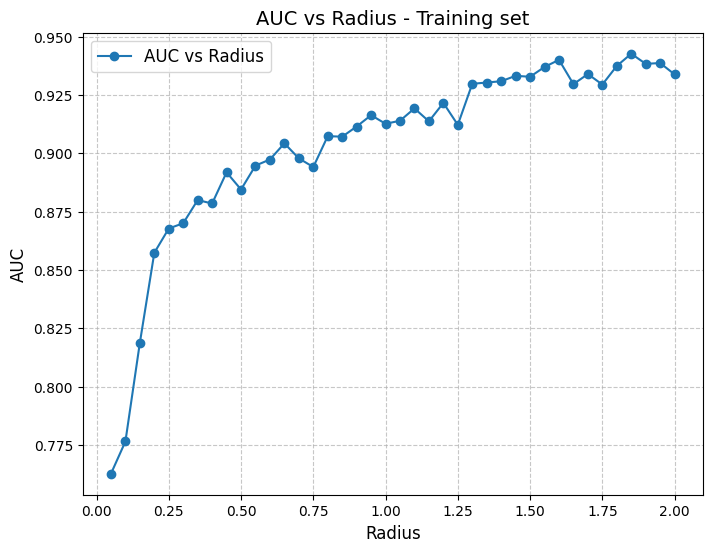

In [ ]:
#training
plt.figure(figsize=(8, 6))
plt.plot(radius, training_metrics['AUC'], marker='o', linestyle='-', label='AUC vs Radius')
plt.title('AUC vs Radius - Training set', fontsize=14)
plt.xlabel('Radius', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

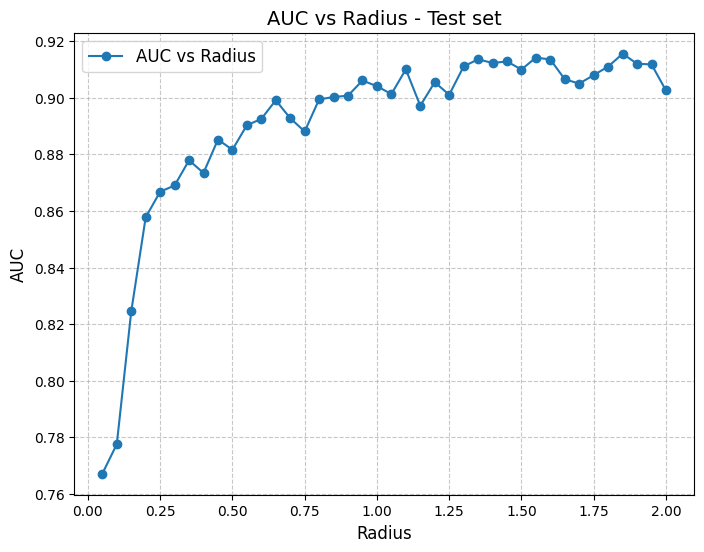

In [ ]:
#test
plt.figure(figsize=(8, 6))
plt.plot(radius, test_metrics['AUC'], marker='o', linestyle='-', label='AUC vs Radius')
plt.title('AUC vs Radius - Test set', fontsize=14)
plt.xlabel('Radius', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()